In [1]:
import warnings
warnings.filterwarnings('ignore')
import sys # Librería para manejo de archivos
import os # Librería para manejo de archivos
sys.path.append(os.path.abspath("..")) 
from scripts.functions import *

# Extracción de datos

La extracción de datos fue realizada mediante **técnicas de web scraping**, utilizando el navegador automatizado **Selenium**. El objetivo de este proceso es descargar los archivos **Excel** que se publica de manera mensual en la página oficial de la **Superintendencia de Banca, Seguros y AFP (SBS) de Perú**. Estos archivos contienen los indicadores financieros de las entidades del país, la información es pública y oficial. Para el desarrollo del proyecto se extrajeron los archivos desde Ago-2015 hasta Ago-2024 ,abarcando un total de 9 años de información.

**Consideraciones en la extracción**

- **Uso de Selenium**: Se utiliza para automatizar la interacción con el navegador, accediendo a la página web de la SBS para obtener los enlaces de los archivos Excel. 
- **Filtrado de enlaces**: Se asegura que solo se descarguen los archivos correspondientes a los meses y años que forman parte del análisis, mediante un sistema de validación que compara las abreviaturas de los meses en los enlaces con las fechas esperadas.
- **Manejo de errores**: El código incluye bloques `try-except` que permiten capturar excepciones durante la descarga de los archivos y así evitar que el proceso se interrumpa por completo.
- **Uso de `requests`**: Se utiliza esta biblioteca para realizar las solicitudes HTTP y descargar los archivos Excel.



In [2]:
chrome_driver_path = "C:/chromedriverw/chromedriver.exe" 
url = "view-source:https://www.sbs.gob.pe/app/stats_net/stats/EstadisticaSistemaFinancieroResultados.aspx?c=B-2401"
output_folder = os.path.join("..", "data", "data_original")

scrape_and_download_excels(chrome_driver_path, url, output_folder)

Archivo B-2401-en2024.XLS descargado correctamente en ..\data\data_original\B-2401-en2024.XLS.
Archivo B-2401-fe2024.XLS descargado correctamente en ..\data\data_original\B-2401-fe2024.XLS.
Archivo B-2401-ma2024.XLS descargado correctamente en ..\data\data_original\B-2401-ma2024.XLS.
Archivo B-2401-ab2024.XLS descargado correctamente en ..\data\data_original\B-2401-ab2024.XLS.
Archivo B-2401-my2024.XLS descargado correctamente en ..\data\data_original\B-2401-my2024.XLS.
Archivo B-2401-jn2024.XLS descargado correctamente en ..\data\data_original\B-2401-jn2024.XLS.
Archivo B-2401-jl2024.XLS descargado correctamente en ..\data\data_original\B-2401-jl2024.XLS.
Archivo B-2401-ag2024.XLS descargado correctamente en ..\data\data_original\B-2401-ag2024.XLS.
Archivo B-2401-se2024.XLS descargado correctamente en ..\data\data_original\B-2401-se2024.XLS.
Archivo B-2401-en2023.XLS descargado correctamente en ..\data\data_original\B-2401-en2023.XLS.
Archivo B-2401-fe2023.XLS descargado correctamente

# Transformación a formato BBDD

Los archivos extraídos requirieron de una transformación inicial a un formato de base de datos para ser procesados, dado que los archivos Excel tenían un formato de tabla distinto al de una base de datos, lo cual dificultaba su procesamiento. Esta tranformación impplicó alguno de los siguientes pasos que se extruturaron en la funcion **transfromar_desde_carpeta**:

- **Cargar Archivos Excel**: Se procesan todos los archivos Excel en una carpeta específica para asegurar que se manejen todos los datos disponibles.
- **Limpieza de Datos**: Se eliminan filas y columnas vacías para mantener solo la información relevante. Esto asegura que el DataFrame resultante contenga solo datos útiles.
- **Formateo de Fechas**: Se extrae la fecha de los nombres de los archivos, convirtiendo abreviaturas de meses a un formato numérico estándar, lo que permite un manejo más sencillo de las fechas.
- **Identificación de Indicadores**: Se categorizan los datos según el tipo de indicador financiero, asegurando que cada fila en el DataFrame resultante esté correctamente clasificada.
- **Filtrado de Nombres de Bancos**: Se valida que los nombres de los bancos sean correctos, eliminando aquellos que no se consideran válidos o que contienen información no deseada.
- **Construcción del DataFrame Final**: Se crea un DataFrame que contiene columnas específicas como "Fecha", "Tipo de Indicador", "Indicador", "Entidad" y "Valor", listando de manera clara y estructurada los datos limpios.
- **Concatenación de Resultados**: Todos los DataFrames procesados se combinan en un único DataFrame final, facilitando así el posterior análisis y almacenamiento en una base de datos.


In [3]:
data_folder = os.path.join("..", "data", "data_original")
df_kpi_bank = transformar_desde_carpeta(os.path.join(data_folder))

In [4]:
df_kpi_bank.head()

,Fecha,Tipo de Indicador,Indicador,Entidad,Valor
0,2016-04-31,SOLVENCIA,Ratio de Capital Global (al 31/03/2016),B. Continental,13.89
1,2016-04-31,SOLVENCIA,Ratio de Capital Global (al 31/03/2016),B. De Comercio,12.14
2,2016-04-31,SOLVENCIA,Ratio de Capital Global (al 31/03/2016),B. De Crédito del Perú,15.00
3,2016-04-31,SOLVENCIA,Ratio de Capital Global (al 31/03/2016),B. Financiero,12.09
4,2016-04-31,SOLVENCIA,Ratio de Capital Global (al 31/03/2016),B. Interamericano de Finanzas,12.51


# Limpieza de datos transformados

Una vez que los datos han sido transformados a una estructura de base de datos, se requiere una limpieza adicional para asegurar la calidad y consistencia de la información.

- **Limpieza General**: Se eliminan caracteres especiales en las columnas de indicadores y entidades, como asteriscos y paréntesis. Esto mejora la legibilidad y la uniformidad de los datos.
- **Reemplazo de Nombres de Entidades**: Se estandarizan los nombres de las entidades financieras. Esto es esencial para evitar duplicados y facilitar el análisis posterior al tener nombres coherentes.
- **Eliminación de Entidades y Indicadores Específicos**:Se eliminan de los datos los bancos 'Deutsche Bank Perú', 'B. Cencosud' debido a que son entidades que ya cerrarón sus oficinas en el país, en el caso de indicador "Posición Global Promedio / Patrimonio Efectivo" se debe a que es un indicador que no está presente en todos los meses de evaluación. 
- **Corrección de Fechas**: Se normalizan las fechas en el DataFrame, manejando diferentes formatos y corrigiendo posibles errores, como días inválidos. Esto asegura que todas las fechas se encuentren en un formato uniforme y utilizable.
- **Preparación para Análisis**: Al finalizar la limpieza, el DataFrame está listo para el análisis, con datos consistentes y bien estructurados, lo que facilita la obtención de insights relevantes.


In [5]:
limpieza_general_data(df_kpi_bank)

,Fecha,Tipo de Indicador,Indicador,Entidad,Valor
0,2016-04-31,SOLVENCIA,Ratio de Capital Global,B. Continental,13.89
1,2016-04-31,SOLVENCIA,Ratio de Capital Global,B. De Comercio,12.14
2,2016-04-31,SOLVENCIA,Ratio de Capital Global,B. De Crédito del Perú,15.00
3,2016-04-31,SOLVENCIA,Ratio de Capital Global,B. Financiero,12.09
4,2016-04-31,SOLVENCIA,Ratio de Capital Global,B. Interamericano de Finanzas,12.51
...,...,...,...,...,...
35625,2024-09-31,LIQUIDEZ,Caja y Bancos en ME / Obligaciones a la Vista ME,B. Ripley,0.00
35626,2024-09-31,LIQUIDEZ,Caja y Bancos en ME / Obligaciones a la Vista ME,Alfin Banco,1.79
35627,2024-09-31,LIQUIDEZ,Caja y Bancos en ME / Obligaciones a la Vista ME,B. ICBC,6.52
35628,2024-09-31,LIQUIDEZ,Caja y Bancos en ME / Obligaciones a la Vista ME,Bank of China,3.27


In [6]:
reemplazo_nombre_entidades(df_kpi_bank)

,Fecha,Tipo de Indicador,Indicador,Entidad,Valor
0,2016-04-31,SOLVENCIA,Ratio de Capital Global,B. BBVA Perú,13.89
1,2016-04-31,SOLVENCIA,Ratio de Capital Global,BANCOM,12.14
2,2016-04-31,SOLVENCIA,Ratio de Capital Global,B. De Crédito del Perú,15.00
3,2016-04-31,SOLVENCIA,Ratio de Capital Global,B. Pichincha,12.09
4,2016-04-31,SOLVENCIA,Ratio de Capital Global,B. Interamericano de Finanzas,12.51
...,...,...,...,...,...
35625,2024-09-31,LIQUIDEZ,Caja y Bancos en ME / Obligaciones a la Vista ME,B. Ripley,0.00
35626,2024-09-31,LIQUIDEZ,Caja y Bancos en ME / Obligaciones a la Vista ME,Alfin Banco,1.79
35627,2024-09-31,LIQUIDEZ,Caja y Bancos en ME / Obligaciones a la Vista ME,B. ICBC,6.52
35628,2024-09-31,LIQUIDEZ,Caja y Bancos en ME / Obligaciones a la Vista ME,Bank of China,3.27


In [7]:
bancos_a_excluir = ['Deutsche Bank Perú', 'B. Cencosud']
indicador_a_eliminar = "Posición Global Promedio / Patrimonio Efectivo"

df_kpi_bank = eliminar_banco_indicador(df_kpi_bank, bancos_a_excluir, indicador_a_eliminar)

In [8]:
df_kpi_bank['Fecha'] = df_kpi_bank['Fecha'].apply(corregir_fecha)

In [9]:
data_save = os.path.join("..", "data", "data_procesada")
df_kpi_bank.to_csv(os.path.join(data_save,"data_kpi_procesada.csv"), index=False)

# Exploracion de datos

Una vez que los datos fueron limpiados, se realizaron diversas etapas de exploración y análisis. A continuación, se detallan los principales hallazgos:

- **Ausencia de Valores Nulos y Duplicados**: Se verificó que no existen valores nulos ni registros duplicados en el dataset. Además, se comprobó que todas las entidades financieras cuentan con la totalidad de los indicadores para las fechas analizadas, lo cual es fundamental para garantizar la integridad del modelado.

- **Exclusión de Entidades Recientes**: Para un análisis más preciso, se excluyeron del estudio a 'Bank of China' y 'B. BCI Perú', ya que son entidades que comenzaron sus operaciones recientemente durante el periodo evaluado, lo que genera datos incompletos que podrían sesgar los resultados.

- **Análisis de Histogramas y Valores Atípicos**: En el análisis inicial de los histogramas de los indicadores, se detectaron valores atípicos. Sin embargo, al profundizar en estos valores, se observó que estaban concentrados principalmente en las entidades nuevas. Al excluir estas entidades del análisis, se evidenció una mejora considerable en la distribución de los datos.

- **Valores Atípicos en Entidades Establecidas**: A pesar de excluir las entidades recientes, se detectaron valores atípicos en indicadores de entidades como Alfin y B. ICBC. Tras revisar estos datos en detalle, se confirmó que no se trataba de errores, sino de fluctuaciones naturales en sus indicadores a lo largo del tiempo.

### Conclusión

La exploración de los datos permitió identificar valores atípicos y ajustar el análisis excluyendo entidades que podrían afectar los resultados debido a su falta de historial. Además, se corroboró que las entidades establecidas con valores extremos presentan comportamientos propios de su dinámica financiera, lo cual será considerado en el análisis futuro.


In [10]:
df_kpi_bank.head()

,Fecha,Tipo de Indicador,Indicador,Entidad,Valor
0,2016-04-30,SOLVENCIA,Ratio de Capital Global,B. BBVA Perú,13.89
1,2016-04-30,SOLVENCIA,Ratio de Capital Global,BANCOM,12.14
2,2016-04-30,SOLVENCIA,Ratio de Capital Global,B. De Crédito del Perú,15.00
3,2016-04-30,SOLVENCIA,Ratio de Capital Global,B. Pichincha,12.09
4,2016-04-30,SOLVENCIA,Ratio de Capital Global,B. Interamericano de Finanzas,12.51


In [11]:
df_kpi_bank.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34172 entries, 0 to 35629
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Fecha              34172 non-null  datetime64[ns]
 1   Tipo de Indicador  34172 non-null  object        
 2   Indicador          34172 non-null  object        
 3   Entidad            34172 non-null  object        
 4   Valor              34172 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 1.6+ MB


In [12]:
entidades_a_excluir = ['Bank of China', 'B. BCI Perú']
identificar_combinaciones_faltantes(df_kpi_bank, entidades_a_excluir)


Todas las entidades (excluyendo las especificadas) tienen todos los indicadores en todas las fechas.


In [13]:
df_kpi_bank.isnull().sum()

Fecha                0
Tipo de Indicador    0
Indicador            0
Entidad              0
Valor                0
dtype: int64

In [14]:
df_kpi_bank.duplicated().sum()

0

In [15]:
df_kpi_bank.nunique()

Fecha                  109
Tipo de Indicador        5
Indicador               20
Entidad                 17
Valor                21471
dtype: int64

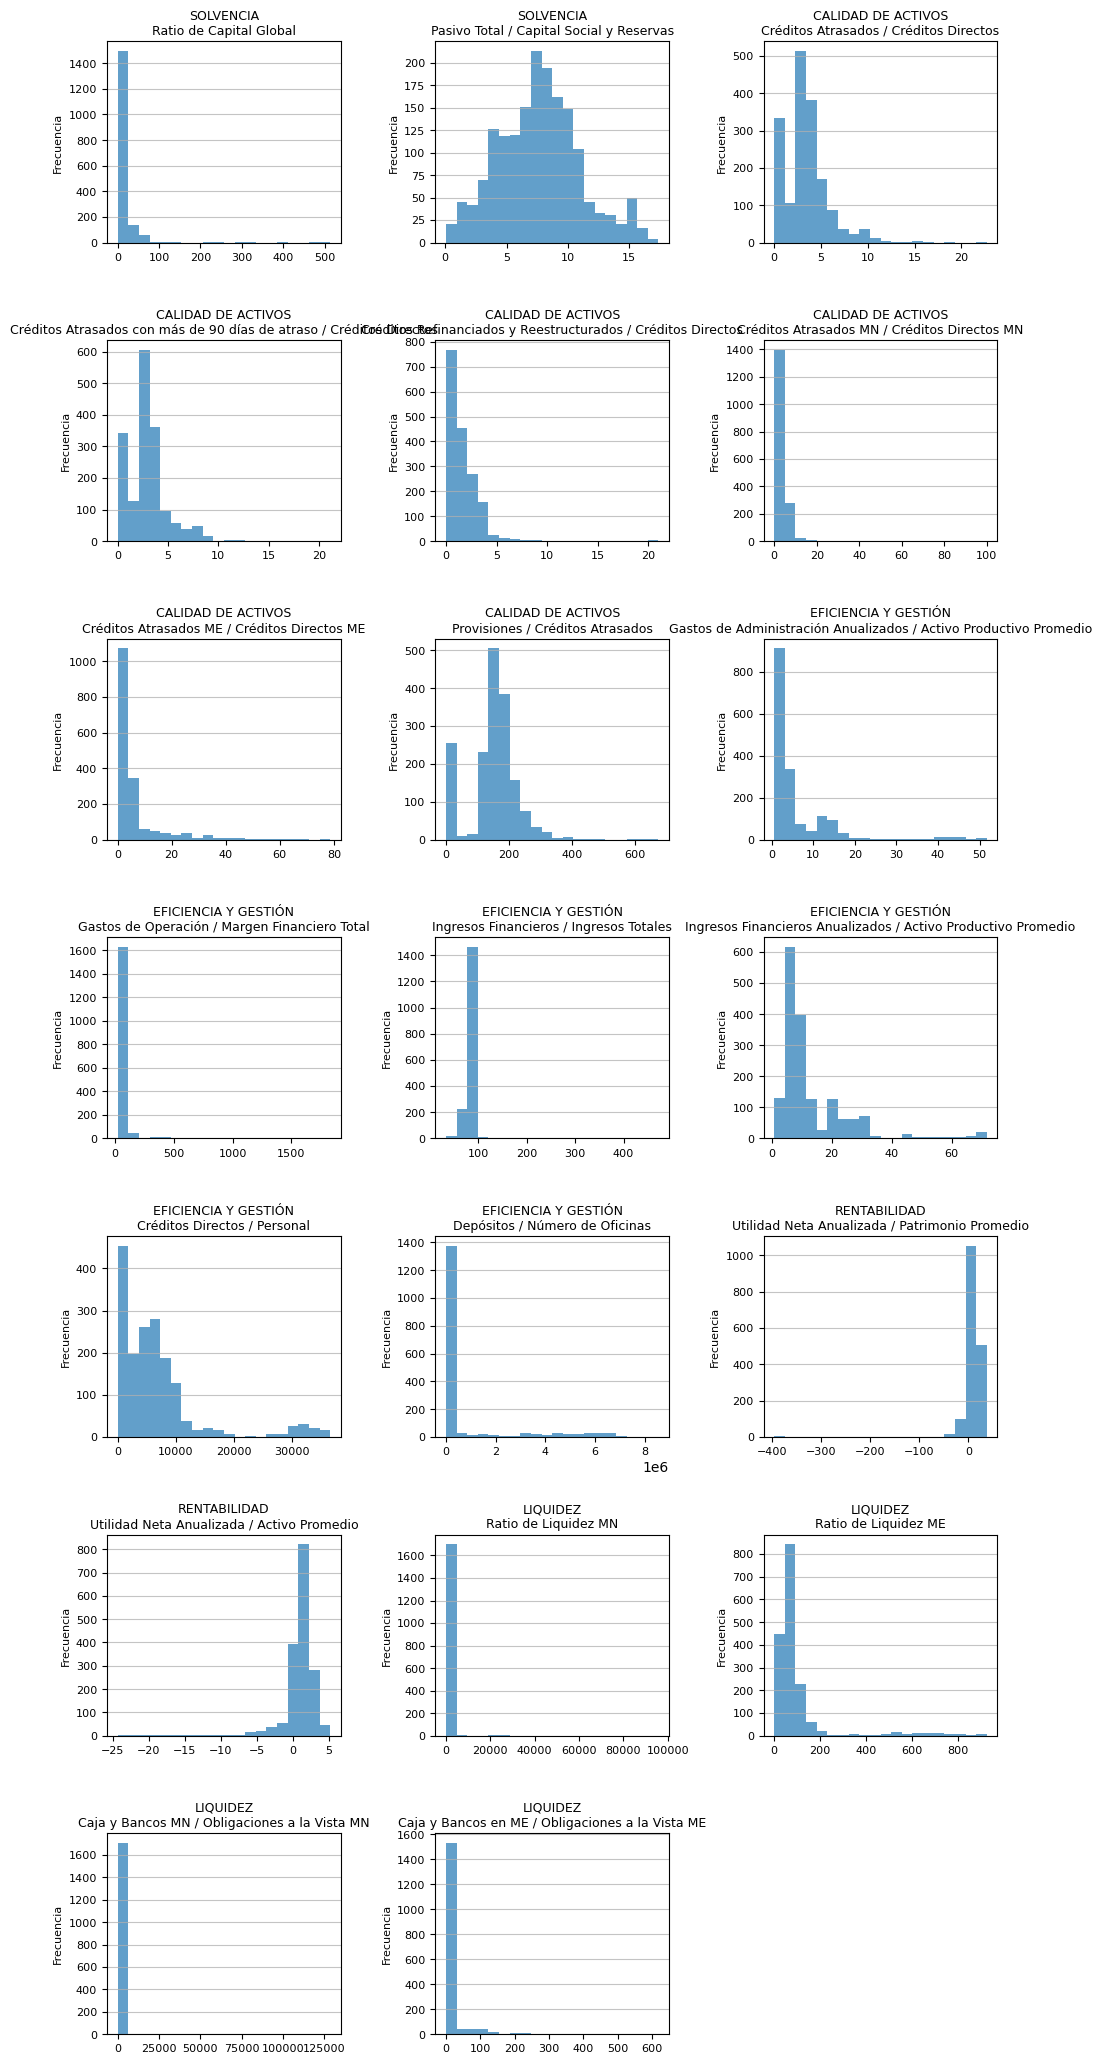

In [16]:
graficar_histogramas_por_tipo(df_kpi_bank)


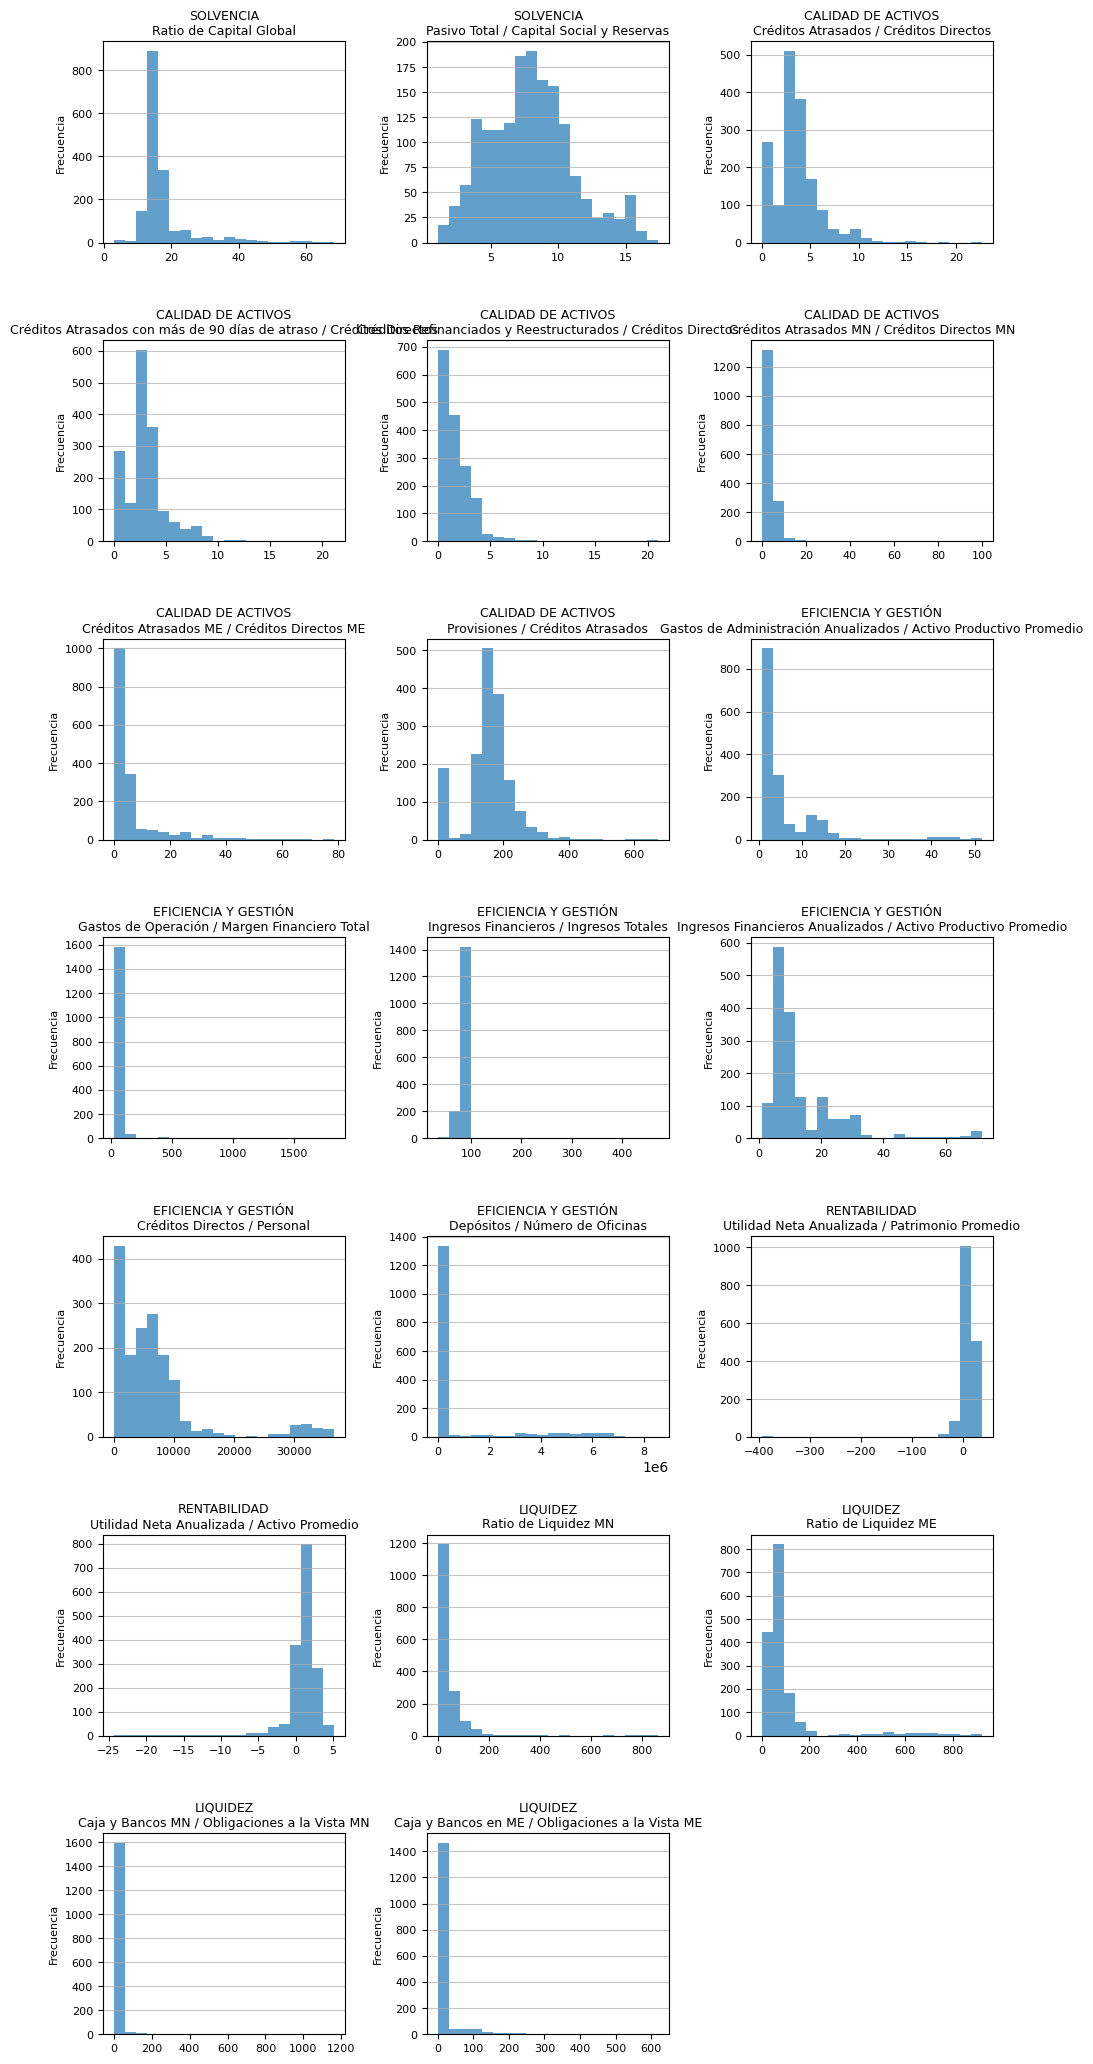

In [17]:
df_filtrado = df_kpi_bank[~df_kpi_bank['Entidad'].isin(['B. BCI Perú', 'Bank of China'])]
graficar_histogramas_por_tipo(df_filtrado)

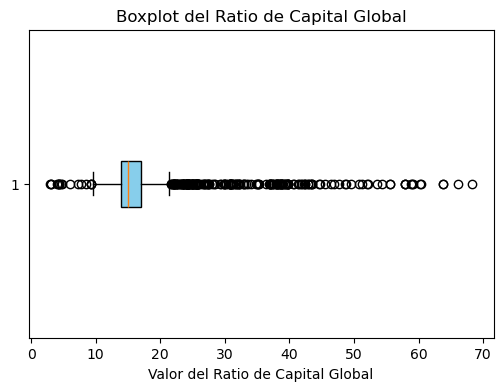

,Fecha,Tipo de Indicador,Indicador,Entidad,Valor
15072,2017-07-31,SOLVENCIA,Ratio de Capital Global,B. ICBC,68.33
3634,2017-08-31,SOLVENCIA,Ratio de Capital Global,B. ICBC,66.08
12149,2017-02-28,SOLVENCIA,Ratio de Capital Global,B. ICBC,63.75
15408,2018-07-31,SOLVENCIA,Ratio de Capital Global,B. ICBC,63.73
20960,2017-03-31,SOLVENCIA,Ratio de Capital Global,B. ICBC,60.34
18369,2018-06-30,SOLVENCIA,Ratio de Capital Global,B. ICBC,60.26
12485,2018-02-28,SOLVENCIA,Ratio de Capital Global,B. ICBC,59.07
33038,2017-09-30,SOLVENCIA,Ratio de Capital Global,B. ICBC,59.02
27469,2018-11-30,SOLVENCIA,Ratio de Capital Global,B. ICBC,58.82
23886,2017-05-31,SOLVENCIA,Ratio de Capital Global,B. ICBC,57.92


In [18]:
detectar_outliers_y_visualizar(df_kpi_bank, 'Ratio de Capital Global', entidades_a_excluir=['B. BCI Perú', 'Bank of China'])

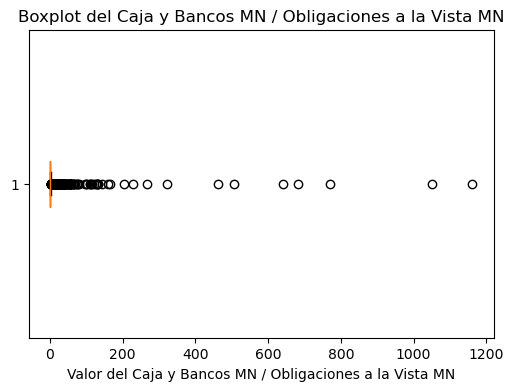

,Fecha,Tipo de Indicador,Indicador,Entidad,Valor
11083,2022-01-31,LIQUIDEZ,Caja y Bancos MN / Obligaciones a la Vista MN,Alfin Banco,1161.78
8156,2021-12-31,LIQUIDEZ,Caja y Bancos MN / Obligaciones a la Vista MN,Alfin Banco,1049.76
16961,2022-07-31,LIQUIDEZ,Caja y Bancos MN / Obligaciones a la Vista MN,Alfin Banco,771.28
28690,2021-11-30,LIQUIDEZ,Caja y Bancos MN / Obligaciones a la Vista MN,Alfin Banco,681.19
14026,2022-02-28,LIQUIDEZ,Caja y Bancos MN / Obligaciones a la Vista MN,Alfin Banco,641.29
31970,2022-10-31,LIQUIDEZ,Caja y Bancos MN / Obligaciones a la Vista MN,Alfin Banco,505.48
25743,2022-05-31,LIQUIDEZ,Caja y Bancos MN / Obligaciones a la Vista MN,Alfin Banco,463.45
19890,2022-06-30,LIQUIDEZ,Caja y Bancos MN / Obligaciones a la Vista MN,Alfin Banco,322.86
2228,2022-04-30,LIQUIDEZ,Caja y Bancos MN / Obligaciones a la Vista MN,Alfin Banco,267.95
22817,2022-03-31,LIQUIDEZ,Caja y Bancos MN / Obligaciones a la Vista MN,Alfin Banco,228.33


In [19]:
detectar_outliers_y_visualizar(df_kpi_bank,'Caja y Bancos MN / Obligaciones a la Vista MN' , entidades_a_excluir=['B. BCI Perú', 'Bank of China'])

# Modelado : Feature engginering - Hiperparámetros

El objetivo del modelado fue aplicar **modelos de clustering** en las series de tiempo de cada indicador para identificar **clústeres de entidades** con comportamientos similares. Para cada indicador, se probaron tres enfoques de clustering:

1. **K-Means (distancia euclidiana)**: Se utilizó la distancia euclidiana tradicional para agrupar las entidades en función de la similitud entre sus series temporales.  
2. **K-Means (distancia DTW)**: Se aplicó K-Means utilizando la distancia **Dynamic Time Warping (DTW)**, que es más adecuada para series temporales al permitir alineaciones no lineales entre las secuencias.   
3. **Shape-Based Clustering**: Se utilizó un modelo de clustering basado en la forma de las series temporales, enfocándose en identificar patrones similares en la estructura de las series.

El objetivo de estos modelos fue agrupar entidades con tendencias y comportamientos comparables en los datos históricos.

- **Feature Engineering**

1. **Estructuración de datos (funcion:`estructurar_data`)**
   - **Filtrado de datos**: Se selecciona solo el indicador deseado y se excluyen los nuevos bancos(por valores faltantes y valores atipicos extremos)
   - **Reorganización**: Los datos se pivotan para obtener series temporales por entidad.
   
2. **Escalado de datos (funcion:`apply_scalers`)**
   - Dado que cada indicador posee caracteriticas que se pudieran acomodar mejor a un tipo de escalado para obtener mejores resultados , se ejecuta los modelos probando sin escalar la serie, y escalando con `RobustScaler` y `StandardScaler`, esto genera versiones escaladas de los datos para comparar el rendimiento de los modelos.

- **Hiperparámetros**

   - El principal parametro para este tipo de modelos es el número de clusters, para lo cual se probaron hasta tres combinaciones de ellos(2,3,4) en busqueda del mejor resultado 
   
- **Resumen evaluación de clustering**
   - Cada modelo se entrena utilizando un indicador específico, probando diferentes combinaciones de datos sin escalar y escalados, además de los tres tipos de clustering mencionados.
   - Se evalúan los modelos mediante el **índice de silueta** para determinar el número óptimo de clústeres.
   - Los resultados del índice de silueta se almacenan en un **DataFrame** para facilitar la comparación entre las distintas configuraciones de los modelos.



A modo de ejemplo se ejecutá el modelo para dos indicadores : Ratio de capital global (RCG) y Ingresos Financieros Anualizados / Activo Productivo Promedio(RatIngAct)

In [20]:
indicador_deseado = 'Ratio de Capital Global'
nuevos_bancos = ['B. BCI Perú', 'Bank of China']
n_clusters_list = [2,3,4]
df_resultado_RCG, df_cluster_RCG = main_pipeline(df_kpi_bank, indicador_deseado, nuevos_bancos, n_clusters_list)

Para este indicador Ratio de Capital Global el mejor resultado se obtien ejecutando el modelo Kmeans(con distancia euclidiana) y escalando lo datos con RobusScaler, logrando una segmentar las entidades en 2 grupos según su evolución temporal del indicador.

In [21]:
df_resultado_RCG.head(10)

,Modelo,Número de Clusters,Configuración,Cluster Labels,Resultado
9,K-Means,2,RobustScaler,"[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.807761
11,DWT,2,RobustScaler,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.807761
0,K-Means,2,Sin escalado,"[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.798710
2,DWT,2,Sin escalado,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.798710
20,DWT,2,StandardScaler,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.778944
18,K-Means,2,StandardScaler,"[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.778944
4,K-Shape,3,Sin escalado,"[2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.676771
15,K-Means,4,RobustScaler,"[2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 3, 1, 1, 1]",0.601291
17,DWT,4,RobustScaler,"[2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 3, 0, 0, 0]",0.601291
12,K-Means,3,RobustScaler,"[2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.588479


In [22]:
df_cluster_RCG

,Entidad,Cluster
0,Alfin Banco,1
1,B. BBVA Perú,1
2,B. De Crédito del Perú,1
3,B. Falabella Perú,1
4,B. GNB,1
5,B. ICBC,0
6,B. Interamericano de Finanzas,1
7,B. Pichincha,1
8,B. Ripley,1
9,B. Santander Perú,1


Para este indicador Ingresos Financieros Anualizados / Activo Productivo Promedio  el mejor resultado se obtiene ejecutando el modelo Kmeans(con distancia euclidiana) y sin escalar los datos, logrando segmentar las entidades en 3 grupos según la evolución temporal del indicador.

In [23]:
indicador_deseado = 'Ingresos Financieros Anualizados / Activo Productivo Promedio'
nuevos_bancos = ['B. BCI Perú', 'Bank of China']
n_clusters_list = [2,3,4]
df_resultado_RatIngAct, df_cluster_RatIngAct = main_pipeline(df_kpi_bank, indicador_deseado, nuevos_bancos, n_clusters_list)

In [24]:
df_resultado_RatIngAct.head(10)

,Modelo,Número de Clusters,Configuración,Cluster Labels,Resultado
3,K-Means,3,Sin escalado,"[2, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]",0.706704
5,DWT,3,Sin escalado,"[2, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]",0.706704
14,DWT,3,RobustScaler,"[2, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]",0.705020
12,K-Means,3,RobustScaler,"[2, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]",0.705020
25,K-Shape,4,StandardScaler,"[1, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2]",0.702909
23,DWT,3,StandardScaler,"[2, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]",0.702909
21,K-Means,3,StandardScaler,"[2, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]",0.702909
20,DWT,2,StandardScaler,"[1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]",0.698500
18,K-Means,2,StandardScaler,"[1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]",0.698500
9,K-Means,2,RobustScaler,"[1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]",0.684647


In [25]:
df_cluster_RatIngAct

,Entidad,Cluster
0,Alfin Banco,2
1,B. BBVA Perú,0
2,B. De Crédito del Perú,0
3,B. Falabella Perú,1
4,B. GNB,0
5,B. ICBC,0
6,B. Interamericano de Finanzas,0
7,B. Pichincha,0
8,B. Ripley,1
9,B. Santander Perú,0


# Resultados totales

... los calculos anteriores se realizan para todos los indicadores obteniendo el modelo que da el mejor resultado para cada uno de ellos, a modo de resumen se estructura un df mostrando los mejores modelos que han dado los mejores resultados por cada indicador ,como se muestra a continuación:

In [26]:
indicadores = df_kpi_bank["Indicador"].unique()
mejores_resultados = []
clasificaciones_totales = []
nuevos_bancos = ['B. BCI Perú', 'Bank of China']
n_clusters_list = [2, 3, 4]

# Bucle para iterar sobre los indicadores
for indicador in indicadores:
    final_results, clasificacion_best_model = main_pipeline(df_kpi_bank, indicador, nuevos_bancos, n_clusters_list)
    # Mejores resultados
    mejor_resultado = final_results.iloc[0]
    mejores_resultados.append({
        'Indicador': indicador,
        'Modelo': mejor_resultado['Modelo'],
        'Número de Clusters': mejor_resultado['Número de Clusters'],
        'Configuración': mejor_resultado['Configuración'],
        'Silhouette Score': mejor_resultado['Resultado']
    })
    #Clasificaciones totales
    clasificaciones_totales.append({
        'Indicador': indicador,
        'Clasificación': clasificacion_best_model
    })

df_mejores_resultados = pd.DataFrame(mejores_resultados)
df_mejores_resultados.sort_values(by= "Silhouette Score", ascending= False)

,Indicador,Modelo,Número de Clusters,Configuración,Silhouette Score
18,Caja y Bancos MN / Obligaciones a la Vista MN,K-Means,2,Sin escalado,0.901836
13,Depósitos / Número de Oficinas,K-Means,2,StandardScaler,0.900128
17,Ratio de Liquidez ME,K-Shape,2,RobustScaler,0.879757
19,Caja y Bancos en ME / Obligaciones a la Vista ME,K-Means,2,RobustScaler,0.856377
16,Ratio de Liquidez MN,K-Means,2,RobustScaler,0.848850
9,Gastos de Operación / Margen Financiero Total,DWT,2,Sin escalado,0.842115
14,Utilidad Neta Anualizada / Patrimonio Promedio,K-Means,2,Sin escalado,0.836440
0,Ratio de Capital Global,K-Means,2,RobustScaler,0.807761
8,Gastos de Administración Anualizados / Activo ...,K-Means,2,Sin escalado,0.795753
12,Créditos Directos / Personal,K-Means,2,RobustScaler,0.787951


Con respecto a los mejores resultados se puede notar que el modelo que mejor se ha adpatado a los indicadores es Kmeans(con distancia euclidiana),seguido de DWT , por otro lado la mayoria de ellos hace una segmentacion de las datos en dos clusters , el Silhoutte Score es relativamente alto -moderado para casi todos los mejores modelos ,mostrando buena cohesion y separación entre clusters, esto a excepción del indicador Pasivo Total / Capital Social y Reservas que muestra un resultado bajo en su mejor modelo.

In [27]:
data_save1 = os.path.join("..", "results")
df_mejores_resultados.to_csv(os.path.join(data_save1,"df_mejores_resultados.csv"), index=False)

En el siguiente cuadro y gráfico se puede obervar los cluster de la entidades obtenidas por cada modelo en cada uno de los indicadores. Solo se considera los indicadores donde su mejor modelo ha tenido una metrica de rendimiento mayor a 0.7 quedando 13 de 19 indicadores. Se desprende lo siguiente:
 - En cada indicador la mayoria de los entidades bancarias estan agrupados en un solo cluster.
 - En la maypria de indicadores el segundo cluster se forma con solo una entidad.
 - Entidades como Alfin Banco y B. ICBC estan presentes en la mayoria de clusters minoritarios.
 - El indicador donde se observa el mayor número de clusters es Ingresos Financieros Anualizados / Activo Productivo Promedio.

In [28]:
resultado_combinado = combinar_clasificaciones(clasificaciones_totales, df_mejores_resultados, umbral_silhouette=0.7)
resultado_combinado

,Entidad,Ratio de Capital Global,Créditos Atrasados MN / Créditos Directos MN,Créditos Atrasados ME / Créditos Directos ME,Gastos de Administración Anualizados / Activo Productivo Promedio,Gastos de Operación / Margen Financiero Total,Ingresos Financieros Anualizados / Activo Productivo Promedio,Créditos Directos / Personal,Depósitos / Número de Oficinas,Utilidad Neta Anualizada / Patrimonio Promedio,Utilidad Neta Anualizada / Activo Promedio,Ratio de Liquidez MN,Ratio de Liquidez ME,Caja y Bancos MN / Obligaciones a la Vista MN,Caja y Bancos en ME / Obligaciones a la Vista ME
0,Alfin Banco,1,1,0,1,1,2,1,1,1,0,1,1,1,0
1,B. BBVA Perú,1,1,0,0,0,0,1,1,0,1,1,1,0,0
2,B. De Crédito del Perú,1,1,0,0,0,0,1,1,0,1,1,1,0,0
3,B. Falabella Perú,1,1,1,0,0,1,1,1,0,1,1,1,0,0
4,B. GNB,1,1,0,0,0,0,1,1,0,1,1,1,0,0
5,B. ICBC,0,0,0,0,0,0,1,1,0,1,0,1,0,0
6,B. Interamericano de Finanzas,1,1,0,0,0,0,1,1,0,1,1,1,0,0
7,B. Pichincha,1,1,0,0,0,0,1,1,0,1,1,1,0,0
8,B. Ripley,1,1,0,0,0,1,1,1,0,1,1,1,0,0
9,B. Santander Perú,1,1,0,0,0,0,0,0,0,1,1,1,0,0


In [29]:
data_save2 = os.path.join("..", "results")
resultado_combinado.to_csv(os.path.join(data_save2,"clusters.csv"), index=False)

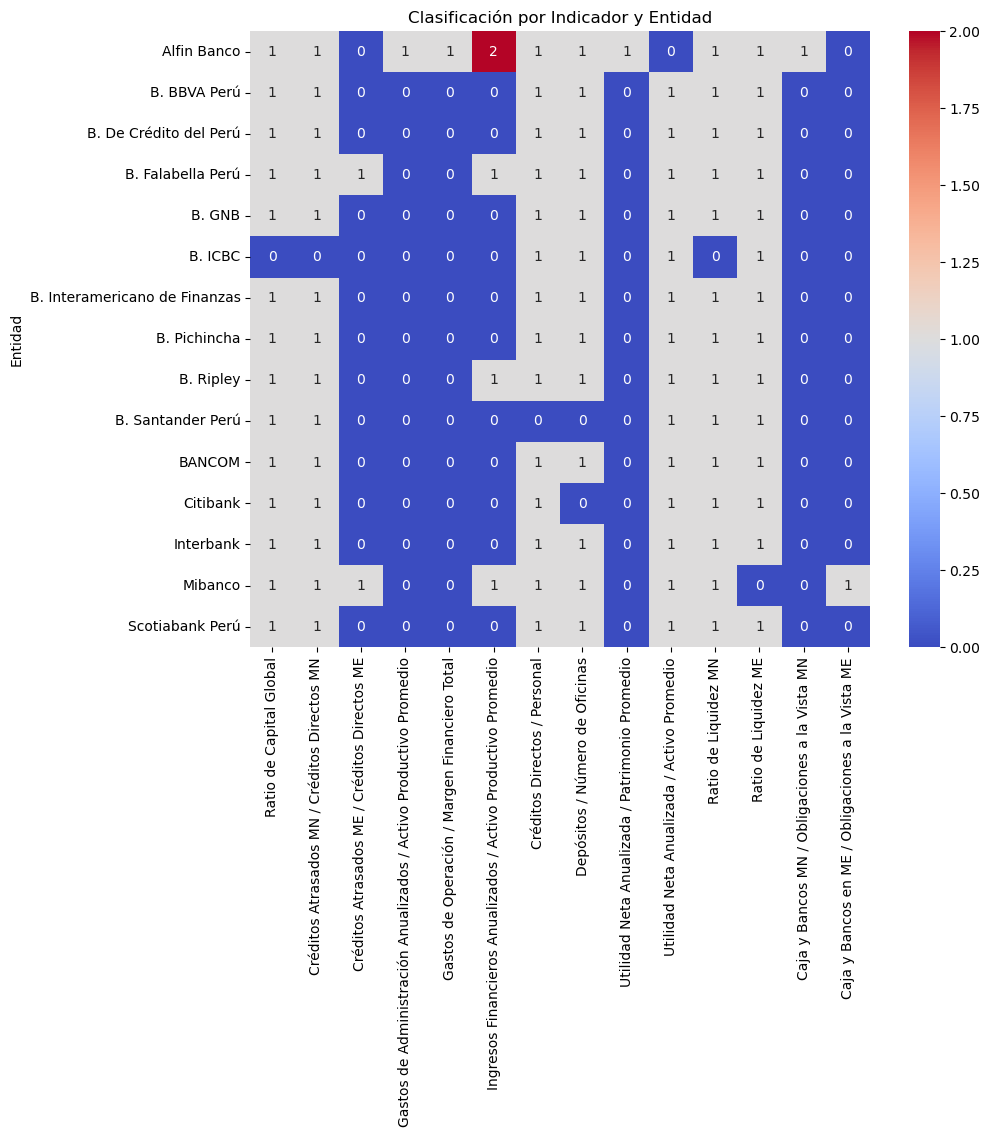

In [30]:
plt.figure(figsize=(10, 8))
sns.heatmap(resultado_combinado.set_index('Entidad'), annot=True, cmap='coolwarm')
plt.title('Clasificación por Indicador y Entidad')
plt.show()

Para un análisis más profundo de los clústeres, se observa la división en los gráficos evolutivos de sus indicadores. A continuación, se detallan los hallazgos más relevantes:

- **Diferencias en los Clústeres**: Los gráficos evidencian claramente los clústeres formados por los modelos, mostrando diferencias significativas entre las entidades que pertenecen a uno o más clústeres.
- **Variaciones en los Indicadores**: Las principales diferencias se manifiestan cuando los indicadores de una entidad presentan valores notablemente más altos o más bajos en comparación con el resto. También se destacan aquellas entidades que han experimentado variaciones marcadas en el pasado.
- **Caso de B. Alfin**: La entidad B. Alfin aparece en 6 indicadores relacionados con gestión, eficiencia y rentabilidad, y se encuentra en el clúster minoritario. Esta inclusión se debe a una marcada variación que experimentó en los años 2021 y 2022. Sin embargo, en los últimos meses, ha mostrado una tendencia de convergencia. Estas variaciones coinciden con cambios significativos en su accionariado principal durante ese período.
- **Caso de B. ICBC**: La entidad B. ICBC está presente en 3 indicadores en el clúster minoritario, que se relacionan con solvencia, calidad de activos y liquidez. En el caso de liquidez y solvencia, su pertenencia a este clúster se debe a que muestra niveles superiores a los de otros bancos. Por otro lado, en cuanto a la calidad de activos, la entidad experimentó una variación notable en el pasado, pero esta situación ya se ha regularizado y actualmente muestra igualdad en los indicadores.
- **Clúster Minoritario en Créditos**: También se evidencia un clúster minoritario en el indicador de créditos atrasados en ME / créditos directos en ME. En este clúster, se encuentran entidades como Mibanco y Falabella, las cuales han aumentado el valor del ratio. Esta situación es preocupante, ya que indica un deterioro en la calidad del activo.


In [31]:
for i in df_mejores_resultados["Indicador"][df_mejores_resultados["Silhouette Score"] > 0.7].unique():
    graficar_resultados(df_kpi_bank, resultado_combinado, nuevos_bancos, [i])
    

## Conclusiones sobre el Análisis de Clústeres

- **Clasificación por Modelos de Aprendizaje Automático no supervisados**: Los clústeres generados por los modelos de aprendizaje automático han demostrado ser efectivos en la clasificación de las entidades financieras según su evolución a lo largo del periodo de análisis. Esta clasificación permite identificar patrones y tendencias que pueden ser de gran utilidad para los responsables de la toma de decisiones en el sector bancario.

- **Similitudes entre Entidades**: La mayoría de las entidades del sistema bancario han mostrado indicadores similares a lo largo del tiempo, lo que se refleja en la presencia mayoritaria de entidades en los diferentes clústeres por indicador. Este fenómeno sugiere que muchas instituciones están influenciadas por factores comunes, como cambios en las políticas regulatorias, condiciones económicas y estrategias de mercado, lo que puede indicar un entorno competitivo homogéneo.

- **Variaciones Históricas de Entidades Específicas**: La inclusión de entidades como B. Alfin y B. ICBC en clústeres minoritarios se debe, principalmente, a variaciones muy marcadas en el pasado. Sin embargo, estas variaciones han sido regularizadas en el tiempo actual, lo que indica una posible recuperación o ajuste en sus estrategias operativas. Este análisis sugiere que estas entidades están en un proceso de estabilización, lo que podría ser indicativo de una gestión más eficiente y consciente de su desempeño en el mercado.

- **Identificación de Deterioros en Activos**: Los modelos también han permitido identificar a entidades como B. Falabella y Mibanco, que presentan deterioros en la calidad de sus activos, especialmente en lo que respecta a monedas extranjeras. Este hallazgo es alarmante, ya que un deterioro en la calidad de activos puede impactar negativamente la solvencia y la reputación de estas instituciones en el mercado.

- **Implicaciones para la Toma de Decisiones**: Estos resultados no solo proporcionan una visión detallada del estado actual de las entidades, sino que también subrayan la importancia de un monitoreo continuo de los indicadores financieros. Las entidades deben estar alertas ante posibles fluctuaciones y adaptarse rápidamente a los cambios del entorno económico y regulatorio. Además, la identificación de clústeres puede servir como base para desarrollar estrategias de segmentación y personalización en productos y servicios bancarios, mejorando así la atención al cliente y la rentabilidad.
